In [1]:
pip install causal-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 2.9 MB/s eta 0:00:00


Code references:
* https://www.pywhy.org/dowhy/v0.11/example_notebooks/dowhy_causal_discovery_example.html
* https://github.com/py-why/causal-learn/issues/180
https://github.com/MIT-LCP/mimic-code/blob/main/mimic-iii/concepts/severityscores/sofa.sql
* https://causallib.readthedocs.io/en/latest/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import io
from google.colab import drive
from google.colab import auth
from google.cloud import bigquery
from google.colab import sheets
from causallearn.search.ConstraintBased.PC import pc
from causallearn.search.ConstraintBased.FCI import fci
from causallearn.utils.GraphUtils import GraphUtils
from sklearn.impute import KNNImputer

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
auth.authenticate_user()

In [5]:
client = bigquery.Client(project='mimic-iv-ventilation')

In [6]:
d_items_df = pd.read_csv('/content/drive/MyDrive/mimic-iv-clinical-database-demo-2.2/icu/d_items.csv.gz')

In [7]:
d_lab_items_df = pd.read_csv('/content/drive/MyDrive/mimic-iv-clinical-database-demo-2.2/hosp/d_labitems.csv.gz')

In [8]:
query = """
    SELECT DISTINCT hadm_id
    FROM `physionet-data.mimiciv_3_1_icu.icustays`
    ORDER BY FARM_FINGERPRINT(CAST(hadm_id AS STRING))
    LIMIT 15000
"""
query_job = client.query(query)
hadm_ids_df = query_job.to_dataframe()

In [9]:
hadm_ids = hadm_ids_df['hadm_id'].tolist()

In [10]:
hadm_ids_str = ", ".join([str(hadm_id) for hadm_id in hadm_ids])

In [11]:
# Extract admissions info
query = f"""
    SELECT *
    FROM `physionet-data.mimiciv_3_1_hosp.admissions`
    WHERE hadm_id IN ({hadm_ids_str})
"""
query_job = client.query(query)
admissions_df = query_job.to_dataframe()

In [12]:
# Find corresponding patient ids
patient_ids = admissions_df['subject_id'].unique()
patient_ids_str = ", ".join([str(patient_id) for patient_id in patient_ids])

In [13]:
# Extract patients info
query = f"""
    SELECT *
    FROM `physionet-data.mimiciv_3_1_hosp.patients`
    WHERE subject_id IN ({patient_ids_str})
"""
query_job = client.query(query)
patients_df = query_job.to_dataframe()

In [14]:
# Extract procedure events
query = f"""
    SELECT *
    FROM `physionet-data.mimiciv_3_1_icu.procedureevents`
    WHERE hadm_id IN ({hadm_ids_str})
"""
query_job = client.query(query)
procedureevents_df = query_job.to_dataframe()

In [15]:
# Extract input events
query = f"""
    SELECT *
    FROM `physionet-data.mimiciv_3_1_icu.inputevents`
    WHERE hadm_id IN ({hadm_ids_str})
"""
query_job = client.query(query)
inputevents_df = query_job.to_dataframe()

In [16]:
# Extract ICU stays
query = f"""
    SELECT *
    FROM `physionet-data.mimiciv_3_1_icu.icustays`
    WHERE hadm_id IN ({hadm_ids_str})
"""
query_job = client.query(query)
icustays_df = query_job.to_dataframe()

In [17]:
# Extract ICU transfers
query = f"""
    SELECT *
    FROM `physionet-data.mimiciv_3_1_hosp.transfers`
    WHERE hadm_id IN ({hadm_ids_str}) AND careunit IN ('Medical Intensive Care Unit (MICU)','Medical/Surgical Intensive Care Unit (MICU/SICU)', 'Surgical Intensive Care Unit (SICU)', 'Cardiac Vascular Intensive Care Unit (CVICU)', 'Trauma SICU (TSICU)', 'Neuro Surgical Intensive Care Unit (Neuro SICU)')
"""
query_job = client.query(query)
transfers_df = query_job.to_dataframe()

In [18]:
# Sort transfers df by subject, admission, and time
transfers_df = transfers_df.sort_values(by=['subject_id', 'hadm_id', 'intime'])

In [19]:
# Filter the df for transfers
transfers_filtered = transfers_df[transfers_df['eventtype'] == 'transfer']

# Add a column for previous care unit
transfers_filtered['previous_careunit'] = transfers_filtered.groupby(['subject_id', 'hadm_id'])['careunit'].shift(1)

# Identify inter-unit transfers
interunit_transfers = transfers_filtered[transfers_filtered['careunit'] != transfers_filtered['previous_careunit']]
for i, row in interunit_transfers.iterrows():
  if pd.notna(row['previous_careunit']):
    interunit_transfers.at[i, 'transfer_occurred'] = True
  else:
    interunit_transfers.at[i, 'transfer_occurred'] = False

<ipython-input-19-9c3844de80c8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transfers_filtered['previous_careunit'] = transfers_filtered.groupby(['subject_id', 'hadm_id'])['careunit'].shift(1)
<ipython-input-19-9c3844de80c8>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interunit_transfers.at[i, 'transfer_occurred'] = False


In [20]:
# Add tranfer_occurred column to transfers_df
transfers_df = pd.merge(transfers_df, interunit_transfers, how='left')

# Change all NaN transfers to False
for i, row in transfers_df.iterrows():
  if row['transfer_occurred'] != True:
    transfers_df.at[i, 'transfer_occurred'] = False

In [21]:
# Aggregate transfers so there is one row per admission
transfers_df = transfers_df.sort_values(by=['hadm_id', 'intime'])

# Separate into true transfers and other
true_transfers = transfers_df[transfers_df['transfer_occurred'] == True]
other_transfers = transfers_df[transfers_df['transfer_occurred'] == False]

# Keep only the first true transfer for each hadm_id
true_transfers = true_transfers.drop_duplicates(subset=['hadm_id'], keep='first')

# Take first non-transfer row for hadm_ids not in true_transfers
non_transfer_hadm_ids = set(transfers_df['hadm_id']) - set(true_transfers['hadm_id'])
filtered_other_transfers = other_transfers[other_transfers['hadm_id'].isin(non_transfer_hadm_ids)]
filtered_other_transfers = filtered_other_transfers.drop_duplicates(subset=['hadm_id'], keep='first')

# Combine the two groups
aggregated_transfers = pd.concat([true_transfers, filtered_other_transfers]).sort_values(by=['hadm_id', 'intime']).reset_index()

In [39]:
# Extract matching data from labevents
query = f"""
    SELECT *
    FROM `physionet-data.mimiciv_3_1_hosp.labevents`
    WHERE hadm_id IN ({hadm_ids_str})
"""

query_job = client.query(query)
labevents_df = query_job.to_dataframe()

In [40]:
# Extract diagnoses for sepsis ICD codes
query = f"""
    SELECT *
    FROM `physionet-data.mimiciv_3_1_hosp.diagnoses_icd`
    WHERE hadm_id IN ({hadm_ids_str})
"""

query_job = client.query(query)
diagnoses_df = query_job.to_dataframe()

In [41]:
# Extract matching data from chartevents
query = f"""
    SELECT *
    FROM `physionet-data.mimiciv_3_1_icu.chartevents`
    WHERE hadm_id IN ({hadm_ids_str})
"""

query_job = client.query(query)
chartevents_df = query_job.to_dataframe()

In [42]:
# Extract relevant chartevents for sepsis label
sepsis_chartevents = chartevents_df[chartevents_df['itemid'].isin([2200045, 223761, 223762, 220045, 220210])]

In [43]:
# Define infection ICD codes
infection_icd_codes = ['A40', 'A41']

# Filter for patients with infection
diagnoses_df['infection'] = diagnoses_df['icd_code'].str.startswith(tuple(infection_icd_codes))
infected_patients = diagnoses_df[diagnoses_df['infection'] == True]

# List of hadm_ids for patients with sepsis infection codes
infected_hadm_ids = infected_patients['hadm_id'].unique().tolist()

In [44]:
relevant_sepsis_chartevents = sepsis_chartevents[sepsis_chartevents['hadm_id'].isin(infected_hadm_ids)]
relevant_lab_events = labevents_df[labevents_df['hadm_id'].isin(infected_hadm_ids)]

In [45]:
# Convert Fahrenheit to Celsius
temp_data = relevant_sepsis_chartevents[relevant_sepsis_chartevents['itemid'] == 223761]
temp_data['temp_celsius'] = (temp_data['valuenum'] - 32) * (5 / 9)
temp_data['sirs_temp'] = (temp_data['temp_celsius'] < 36) | (temp_data['temp_celsius'] > 38)

# Filter for heart rate
hr_data = relevant_sepsis_chartevents[relevant_sepsis_chartevents['itemid'] == 220045]
hr_data['sirs_hr'] = hr_data['valuenum'] > 90

# Filter for respiratory rate
rr_data = relevant_sepsis_chartevents[relevant_sepsis_chartevents['itemid'] == 220210]
rr_data['sirs_rr'] = rr_data['valuenum'] > 20

# Filter for WBC
wbc_data = relevant_lab_events[relevant_lab_events['itemid'] == 51301]
wbc_data['sirs_wbc'] = (wbc_data['valuenum'] < 4) | (wbc_data['valuenum'] > 12)

# Merge SIRS criteria
sirs_data = pd.concat([temp_data[['hadm_id', 'charttime', 'sirs_temp']],
                       hr_data[['hadm_id', 'charttime', 'sirs_hr']],
                       rr_data[['hadm_id', 'charttime', 'sirs_rr']],
                       wbc_data[['hadm_id', 'charttime', 'sirs_wbc']]], axis=0)

<ipython-input-45-47adf2701945>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_data['temp_celsius'] = (temp_data['valuenum'] - 32) * (5 / 9)
<ipython-input-45-47adf2701945>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_data['sirs_temp'] = (temp_data['temp_celsius'] < 36) | (temp_data['temp_celsius'] > 38)
<ipython-input-45-47adf2701945>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [46]:
# Resample data hourly and interpolate missing values
sirs_data['charttime'] = pd.to_datetime(sirs_data['charttime'])
sirs_data = sirs_data.groupby(['hadm_id', pd.Grouper(key='charttime', freq='h')]).mean()

# Ensure only numeric columns are included in interpolation
numeric_columns = sirs_data.select_dtypes(include=['float64', 'int64']).columns
sirs_data[numeric_columns] = sirs_data[numeric_columns].interpolate(method='linear').fillna(method='ffill')

# Check for SIRS (at least 2 criteria met)
sirs_data['sirs_count'] = sirs_data[['sirs_temp', 'sirs_hr', 'sirs_rr', 'sirs_wbc']].sum(axis=1)
sirs_data['sirs_met'] = sirs_data['sirs_count'] >= 2

# Add a rolling 5-hour window to check for SIRS criteria
sirs_data['sirs_5hour'] = (
    sirs_data.groupby('hadm_id')['sirs_met']
    .transform(lambda x: x.rolling(window=5, min_periods=5).sum() >= 5)
)

# Identify sepsis onset: first time SIRS criteria are met for 5 consecutive hours
sepsis_data = sirs_data.reset_index().merge(infected_patients[['hadm_id']], on='hadm_id', how='inner')
sepsis_data = sepsis_data[sepsis_data['sirs_5hour'] == True]
sepsis_onset = sepsis_data.groupby('hadm_id')['charttime'].min().reset_index()
sepsis_onset.rename(columns={'charttime': 'sepsis_onset_time'}, inplace=True)


<ipython-input-46-fa14d935e9bb>:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sirs_data[numeric_columns] = sirs_data[numeric_columns].interpolate(method='linear').fillna(method='ffill')


In [47]:
# Create dataset for causal inference
# Initialize with hadm_id
wrangled_df = pd.DataFrame({'hadm_id': hadm_ids_df['hadm_id']})

# Add treatment variable: inter-unit ICU transfer
wrangled_df = pd.merge(wrangled_df, aggregated_transfers, on='hadm_id', how='left')

# Fill missing transfer information for non-transfers
wrangled_df['transfer_occurred'] = wrangled_df['transfer_occurred'].fillna(False)

# Add response variable: sepsis outcome
wrangled_df = pd.merge(wrangled_df, sepsis_onset, on='hadm_id', how='left')
wrangled_df['sepsis_occurred'] = ~wrangled_df['sepsis_onset_time'].isna()

# Final wrangled dataset
wrangled_df.reset_index(drop=True, inplace=True)


<ipython-input-47-10c9f808de17>:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  wrangled_df['transfer_occurred'] = wrangled_df['transfer_occurred'].fillna(False)


Extracting confounders

In [48]:
# Merge demographics and admission details
confounders = admissions_df[['subject_id', 'hadm_id', 'admittime']].copy()
confounders = confounders.merge(patients_df[['subject_id', 'gender', 'anchor_age']], on='subject_id', how='left')

# Drop columns not needed
confounders = confounders.drop(['admittime'], axis=1)

In [49]:
# Define comorbidity ICD code groups
comorbidities = {
    'diabetes': ['E10', 'E11'],
    'hypertension': ['I10', 'I11', 'I12'],
    'heart_disease': ['I20', 'I21', 'I22', 'I50']
}

# Add binary flags for each comorbidity
for comorbidity, codes in comorbidities.items():
    diagnoses_df[comorbidity] = diagnoses_df['icd_code'].str.startswith(tuple(codes))

# Aggregate comorbidities at the admission level
comorbidity_flags = diagnoses_df.groupby('hadm_id').agg({
    'diabetes': 'max',
    'hypertension': 'max',
    'heart_disease': 'max'
}).reset_index()


In [50]:
# Ensure datetime columns are properly formatted
labevents_df['charttime'] = pd.to_datetime(labevents_df['charttime'])
wrangled_df['intime'] = pd.to_datetime(wrangled_df['intime'])
wrangled_df['sepsis_onset_time'] = pd.to_datetime(wrangled_df['sepsis_onset_time'])

# Merge transfer and sepsis onset times with lab events
labevents_df = labevents_df.merge(
    wrangled_df[['hadm_id', 'intime', 'sepsis_onset_time']], on='hadm_id', how='left'
)

# Filter for creatinine measurements
creatinine_itemid = 50912  # Item ID for creatinine

# Calculate average creatinine before transfer
creatinine_before_transfer = labevents_df[
    (labevents_df['itemid'] == creatinine_itemid) &
    (labevents_df['charttime'] < labevents_df['intime'])
]
creatinine_before_transfer = (
    creatinine_before_transfer.groupby('hadm_id')['valuenum']
    .mean()
    .reset_index()
    .rename(columns={'valuenum': 'avg_creatinine_before_transfer'})
)

# Calculate average creatinine between transfer and sepsis
creatinine_between_transfer_and_sepsis = labevents_df[
    (labevents_df['itemid'] == creatinine_itemid) &
    (labevents_df['charttime'] >= labevents_df['intime']) &
    (labevents_df['charttime'] < labevents_df['sepsis_onset_time'])
]
creatinine_between_transfer_and_sepsis = (
    creatinine_between_transfer_and_sepsis.groupby('hadm_id')['valuenum']
    .mean()
    .reset_index()
    .rename(columns={'valuenum': 'avg_creatinine_between_transfer_and_sepsis'})
)

# Merge results into wrangled_df
wrangled_df = wrangled_df.merge(creatinine_before_transfer, on='hadm_id', how='left')
wrangled_df = wrangled_df.merge(creatinine_between_transfer_and_sepsis, on='hadm_id', how='left')

# Final wrangled_df contains average creatinine values for the specified time windows

In [51]:
# Define GCS item IDs
gcs_items = {
    'eye': [220739],      # Eye response
    'motor': [223901],    # Motor response
    'verbal': [223900]    # Verbal response
}

# Filter the chartevents data for GCS item IDs
gcs_data = chartevents_df[chartevents_df['itemid'].isin(gcs_items['eye'] + gcs_items['motor'] + gcs_items['verbal'])]

# Merge GCS data with wrangled_df to get only the records for included admissions
gcs_data = gcs_data[gcs_data['hadm_id'].isin(wrangled_df['hadm_id'])]

# Convert 'charttime' to datetime if not already
gcs_data['charttime'] = pd.to_datetime(gcs_data['charttime'])

# Merge with transfer and sepsis times to filter GCS before and after transfer
gcs_data = pd.merge(
    gcs_data,
    wrangled_df[['hadm_id', 'transfer_id', 'intime', 'sepsis_onset_time']],
    on='hadm_id',
    how='left'
)

# Pivot the data to have one column for each GCS component (eye, motor, verbal)
gcs_data_pivot = gcs_data.pivot_table(
    index=['hadm_id', 'charttime', 'intime', 'sepsis_onset_time'],
    columns='itemid',
    values='valuenum'
).reset_index()

# Rename columns for clarity
gcs_data_pivot.rename(
    columns={
        220739: 'gcs_eye',
        223901: 'gcs_motor',
        223900: 'gcs_verbal'
    },
    inplace=True
)

# Ensure no missing columns in the pivoted data
required_columns = ['gcs_eye', 'gcs_motor', 'gcs_verbal']
for col in required_columns:
    if col not in gcs_data_pivot:
        gcs_data_pivot[col] = 0  # Assign 0 if a column is missing

# Calculate total GCS score
gcs_data_pivot['gcs_total'] = gcs_data_pivot[required_columns].sum(axis=1)

# Separate GCS data into before transfer and after transfer but before sepsis
gcs_before_transfer = gcs_data_pivot[
    gcs_data_pivot['charttime'] < gcs_data_pivot['intime']
]
gcs_after_transfer_before_sepsis = gcs_data_pivot[
    (gcs_data_pivot['charttime'] >= gcs_data_pivot['intime']) &
    (gcs_data_pivot['charttime'] < gcs_data_pivot['sepsis_onset_time'])
]

# Debugging: Check if the filtered DataFrames are empty
if gcs_before_transfer.empty:
    print("Warning: gcs_before_transfer is empty.")
if gcs_after_transfer_before_sepsis.empty:
    print("Warning: gcs_after_transfer_before_sepsis is empty.")

# Get the average GCS score before transfer for each patient
gcs_before_transfer_avg = gcs_before_transfer.groupby('hadm_id')['gcs_total'].mean().reset_index()
gcs_before_transfer_avg.rename(columns={'gcs_total': 'gcs_before_transfer'}, inplace=True)

# Get the average GCS score after transfer but before sepsis for each patient
gcs_after_transfer_before_sepsis_avg = gcs_after_transfer_before_sepsis.groupby('hadm_id')['gcs_total'].mean().reset_index()
gcs_after_transfer_before_sepsis_avg.rename(columns={'gcs_total': 'gcs_after_transfer_before_sepsis'}, inplace=True)

# Debugging: Check column names before merging
print("gcs_before_transfer_avg columns:", gcs_before_transfer_avg.columns)
print("gcs_after_transfer_before_sepsis_avg columns:", gcs_after_transfer_before_sepsis_avg.columns)

# Merge the GCS scores back into wrangled_df
wrangled_df = pd.merge(wrangled_df, gcs_before_transfer_avg, on='hadm_id', how='left')
wrangled_df = pd.merge(wrangled_df, gcs_after_transfer_before_sepsis_avg, on='hadm_id', how='left')

# Fill missing values with 0 or other appropriate value
wrangled_df['gcs_before_transfer'] = wrangled_df['gcs_before_transfer'].fillna(0)
wrangled_df['gcs_after_transfer_before_sepsis'] = wrangled_df['gcs_after_transfer_before_sepsis'].fillna(0)

gcs_before_transfer_avg columns: Index(['hadm_id', 'gcs_before_transfer'], dtype='object')
gcs_after_transfer_before_sepsis_avg columns: Index(['hadm_id', 'gcs_after_transfer_before_sepsis'], dtype='object')


In [52]:
# Combine all confounders
confounders = confounders.merge(comorbidity_flags, on='hadm_id', how='left')

# Merge with wrangled_df
wrangled_df = wrangled_df.merge(confounders, on='hadm_id', how='left')


In [114]:
# Ensure datetime columns are in proper datetime format
icustays_df['intime'] = pd.to_datetime(icustays_df['intime'])
icustays_df['outtime'] = pd.to_datetime(icustays_df['outtime'])

# For each ICU stay, calculate the length of stay
icustays_df['icu_los_individual'] = (icustays_df['outtime'] - icustays_df['intime']).dt.total_seconds() / 3600  # Convert to hours

# Sort ICU stays by admission ID and intime
icustays_df = icustays_df.sort_values(by=['hadm_id', 'intime'])

# Calculate cumulative ICU length of stay for each admission up to (but not including) the specific transfer
def calculate_cumulative_los_before_transfer(row, icustays_df):
    hadm_id = row['hadm_id']
    transfer_time = row['intime']

    # Filter ICU stays for the same hospital admission and before the specific transfer time
    relevant_stays = icustays_df[(icustays_df['hadm_id'] == hadm_id) & (icustays_df['intime'] < transfer_time)]

    # Calculate cumulative length of stay
    cumulative_los = relevant_stays['icu_los_individual'].sum()
    return cumulative_los

# Apply the calculation to the wrangled_df
wrangled_df['icu_los_before_transfer'] = wrangled_df.apply(
    lambda row: calculate_cumulative_los_before_transfer(row, icustays_df),
    axis=1
)

# Fill missing ICU LOS with 0 for admissions without prior ICU stays
wrangled_df['icu_los_before_transfer'] = wrangled_df['icu_los_before_transfer'].fillna(0)


In [54]:
# Count comorbidities for each admission
comorbidity_count = diagnoses_df.groupby('hadm_id')['icd_code'].nunique().reset_index()
comorbidity_count.rename(columns={'icd_code': 'comorbidity_count'}, inplace=True)

# Merge with wrangled_df
wrangled_df = wrangled_df.merge(comorbidity_count, on='hadm_id', how='left')

In [55]:
# Search for antibiotics in D_ITEMS
antibiotic_items = d_items_df[d_items_df['label'].str.contains('antibiotic|antimicrobial|vancomycin|ceftriaxone', case=False, na=False)]
antibiotic_item_ids = antibiotic_items['itemid'].tolist()

# Identify first antibiotic administration time for each admission
antibiotics = inputevents_df[inputevents_df['itemid'].isin(antibiotic_item_ids)]  # Replace with specific item IDs
antibiotics_timing = antibiotics.groupby('hadm_id')['starttime'].min().reset_index()
antibiotics_timing.rename(columns={'starttime': 'first_antibiotic_time'}, inplace=True)

# Merge with wrangled_df
wrangled_df = wrangled_df.merge(antibiotics_timing, on='hadm_id', how='left')

# Add binary flags for whether antibiotics were administered
wrangled_df['antibiotic_used'] = ~wrangled_df['first_antibiotic_time'].isna()

# Add dual flags for antibiotic administration
# 1. Antibiotics administered before transfer
wrangled_df['antibiotic_before_transfer'] = (
    wrangled_df['first_antibiotic_time'] < wrangled_df['intime']
)
wrangled_df['antibiotic_before_transfer'] = wrangled_df['antibiotic_before_transfer'].fillna(False)

# 2. Antibiotics administered between transfer and sepsis
wrangled_df['antibiotic_after_transfer_before_sepsis'] = (
    (wrangled_df['first_antibiotic_time'] >= wrangled_df['intime']) &
    (wrangled_df['first_antibiotic_time'] < wrangled_df['sepsis_onset_time'])
)
wrangled_df['antibiotic_after_transfer_before_sepsis'] = wrangled_df['antibiotic_after_transfer_before_sepsis'].fillna(False)

In [56]:
# Search for vasopressors in D_ITEMS
vasopressor_items = d_items_df[d_items_df['label'].str.contains('norepinephrine|epinephrine|vasopressin|dopamine|dobutamine', case=False, na=False)]
vasopressor_item_ids = vasopressor_items['itemid'].tolist()

# Find the first time vasopressors were administered
vasopressor_timing = inputevents_df[inputevents_df['itemid'].isin(vasopressor_item_ids)]
vasopressor_timing = vasopressor_timing.groupby('hadm_id')['starttime'].min().reset_index()
vasopressor_timing.rename(columns={'starttime': 'first_vasopressor_time'}, inplace=True)

# Merge with wrangled_df
wrangled_df = wrangled_df.merge(vasopressor_timing, on='hadm_id', how='left')

# Add binary flags for whether vasopressors were used
wrangled_df['vasopressor_used'] = ~wrangled_df['first_vasopressor_time'].isna()

# Add dual flags for vasopressor administration
# 1. Vasopressors administered before transfer
wrangled_df['vasopressor_before_transfer'] = (
    wrangled_df['first_vasopressor_time'] < wrangled_df['intime']
)
wrangled_df['vasopressor_before_transfer'] = wrangled_df['vasopressor_before_transfer'].fillna(False)

# 2. Vasopressors administered between transfer and sepsis
wrangled_df['vasopressor_after_transfer_before_sepsis'] = (
    (wrangled_df['first_vasopressor_time'] >= wrangled_df['intime']) &
    (wrangled_df['first_vasopressor_time'] < wrangled_df['sepsis_onset_time'])
)
wrangled_df['vasopressor_after_transfer_before_sepsis'] = wrangled_df['vasopressor_after_transfer_before_sepsis'].fillna(False)

# Final binary flags
print(wrangled_df[['vasopressor_used', 'vasopressor_before_transfer', 'vasopressor_after_transfer_before_sepsis']].head())


   vasopressor_used  vasopressor_before_transfer  \
0             False                        False   
1             False                        False   
2              True                        False   
3             False                        False   
4             False                        False   

   vasopressor_after_transfer_before_sepsis  
0                                     False  
1                                     False  
2                                     False  
3                                     False  
4                                     False  


In [57]:
# Search for invasive procedures in D_ITEMS
invasive_procedure_items = d_items_df[d_items_df['label'].str.contains('intubation|ventilation|central line|arterial catheter', case=False, na=False)]
invasive_procedure_item_ids = invasive_procedure_items['itemid'].tolist()

# Find the first time invasive procedures were performed
procedure_timing = procedureevents_df[procedureevents_df['itemid'].isin(invasive_procedure_item_ids)]
procedure_timing = procedure_timing.groupby('hadm_id')['starttime'].min().reset_index()
procedure_timing.rename(columns={'starttime': 'first_procedure_time'}, inplace=True)

# Merge with wrangled_df
wrangled_df = wrangled_df.merge(procedure_timing, on='hadm_id', how='left')

# Add binary flags for whether procedure was done
wrangled_df['procedure_performed'] = ~wrangled_df['first_procedure_time'].isna()

# 1. Procedure before transfer
wrangled_df['procedure_before_transfer'] = (
    wrangled_df['first_procedure_time'] < wrangled_df['intime']
)
wrangled_df['procedure_before_transfer'] = wrangled_df['procedure_before_transfer'].fillna(False)

# 2. Procedure between transfer and sepsis
wrangled_df['procedure_after_transfer_before_sepsis'] = (
    (wrangled_df['first_procedure_time'] >= wrangled_df['intime']) &
    (wrangled_df['first_procedure_time'] < wrangled_df['sepsis_onset_time'])
)
wrangled_df['procedure_after_transfer_before_sepsis'] = wrangled_df['procedure_after_transfer_before_sepsis'].fillna(False)

# ////




In [115]:
wrangled_df.columns

Index(['hadm_id', 'index', 'subject_id_x', 'transfer_id', 'eventtype',
       'careunit', 'intime', 'outtime', 'previous_careunit',
       'transfer_occurred', 'sepsis_onset_time', 'sepsis_occurred',
       'avg_creatinine_before_transfer',
       'avg_creatinine_between_transfer_and_sepsis', 'gcs_before_transfer',
       'gcs_after_transfer_before_sepsis', 'subject_id_y', 'gender',
       'anchor_age', 'diabetes', 'hypertension', 'heart_disease', 'icu_los',
       'comorbidity_count', 'first_antibiotic_time', 'antibiotic_used',
       'antibiotic_before_transfer', 'antibiotic_after_transfer_before_sepsis',
       'first_vasopressor_time', 'vasopressor_used',
       'vasopressor_before_transfer',
       'vasopressor_after_transfer_before_sepsis', 'first_procedure_time',
       'procedure_performed', 'procedure_before_transfer',
       'procedure_after_transfer_before_sepsis', 'icu_los_before_transfer'],
      dtype='object')

In [116]:
# Normalize continuous columns
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
continuous_columns = ['comorbidity_count', 'icu_los_before_transfer', 'anchor_age']
wrangled_df[continuous_columns] = scaler.fit_transform(wrangled_df[continuous_columns])

In [117]:
# Fill in missing values for relevant columns
categorical_columns = ['gender']
for col in categorical_columns:
    wrangled_df[col] = wrangled_df[col].fillna('Unknown')

In [118]:
# Ensure datetime columns are in the correct format
wrangled_df['outtime'] = pd.to_datetime(wrangled_df['outtime'])
wrangled_df['sepsis_onset_time'] = pd.to_datetime(wrangled_df['sepsis_onset_time'])

# Filter rows where transfers occurred before sepsis onset
filtered_dataset = wrangled_df[
    (wrangled_df['outtime'] <= wrangled_df['sepsis_onset_time']) | wrangled_df['sepsis_onset_time'].isna()
]

# Reset the index for clarity
filtered_dataset.reset_index(drop=True, inplace=True)


In [119]:
final_df = filtered_dataset.drop(['hadm_id', 'index', 'subject_id_x', 'transfer_id', 'eventtype', 'careunit', 'intime', 'outtime', 'previous_careunit', 'sepsis_onset_time', 'subject_id_y', 'first_antibiotic_time', 'first_vasopressor_time', 'vasopressor_used', 'first_procedure_time', 'procedure_performed', 'icu_los'], axis=1)

In [120]:
# Use one-hot encoding for categorical variables
final_df = pd.get_dummies(final_df, columns=['transfer_occurred', 'sepsis_occurred', 'gender'])

# Identify redundant dummy variables ending in "_False"
redundant_columns = [col for col in final_df.columns if col.endswith('_False') or col.endswith('_M')]

# Drop redundant dummy variables
dataset = final_df.drop(columns=redundant_columns)

In [123]:
# Impute missing values
continuous_vars = ['avg_creatinine_before_transfer', 'avg_creatinine_between_transfer_and_sepsis', 'comorbidity_count', 'hypertension', 'heart_disease', 'icu_los_before_transfer', 'diabetes']
imputer = KNNImputer(n_neighbors=5)
dataset[continuous_vars] = imputer.fit_transform(dataset[continuous_vars])

In [124]:
print(dataset.isna().sum())

avg_creatinine_before_transfer                0
avg_creatinine_between_transfer_and_sepsis    0
gcs_before_transfer                           0
gcs_after_transfer_before_sepsis              0
anchor_age                                    0
diabetes                                      0
hypertension                                  0
heart_disease                                 0
comorbidity_count                             0
antibiotic_used                               0
antibiotic_before_transfer                    0
antibiotic_after_transfer_before_sepsis       0
vasopressor_before_transfer                   0
vasopressor_after_transfer_before_sepsis      0
procedure_before_transfer                     0
procedure_after_transfer_before_sepsis        0
icu_los_before_transfer                       0
transfer_occurred_True                        0
sepsis_occurred_True                          0
gender_F                                      0
dtype: int64


Causal discovery using the PC algorithm

In [125]:
corr_matrix = dataset.corr().abs()

# Select the upper triangle of the correlation matrix
upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# Find pairs of features with correlation = 1.0
perfectly_correlated = [
    (column, index) for column in upper_triangle.columns
    for index in upper_triangle.index
    if upper_triangle.loc[index, column] == 1.0
]

# Display the perfectly correlated pairs
print("Perfectly correlated variable pairs:")
for pair in perfectly_correlated:
    print(pair)

Perfectly correlated variable pairs:


In [126]:
data = dataset.to_numpy()

# Convert the data to numeric
data = data.astype(float)

In [127]:
pc_result = pc(data)

  0%|          | 0/20 [00:00<?, ?it/s]

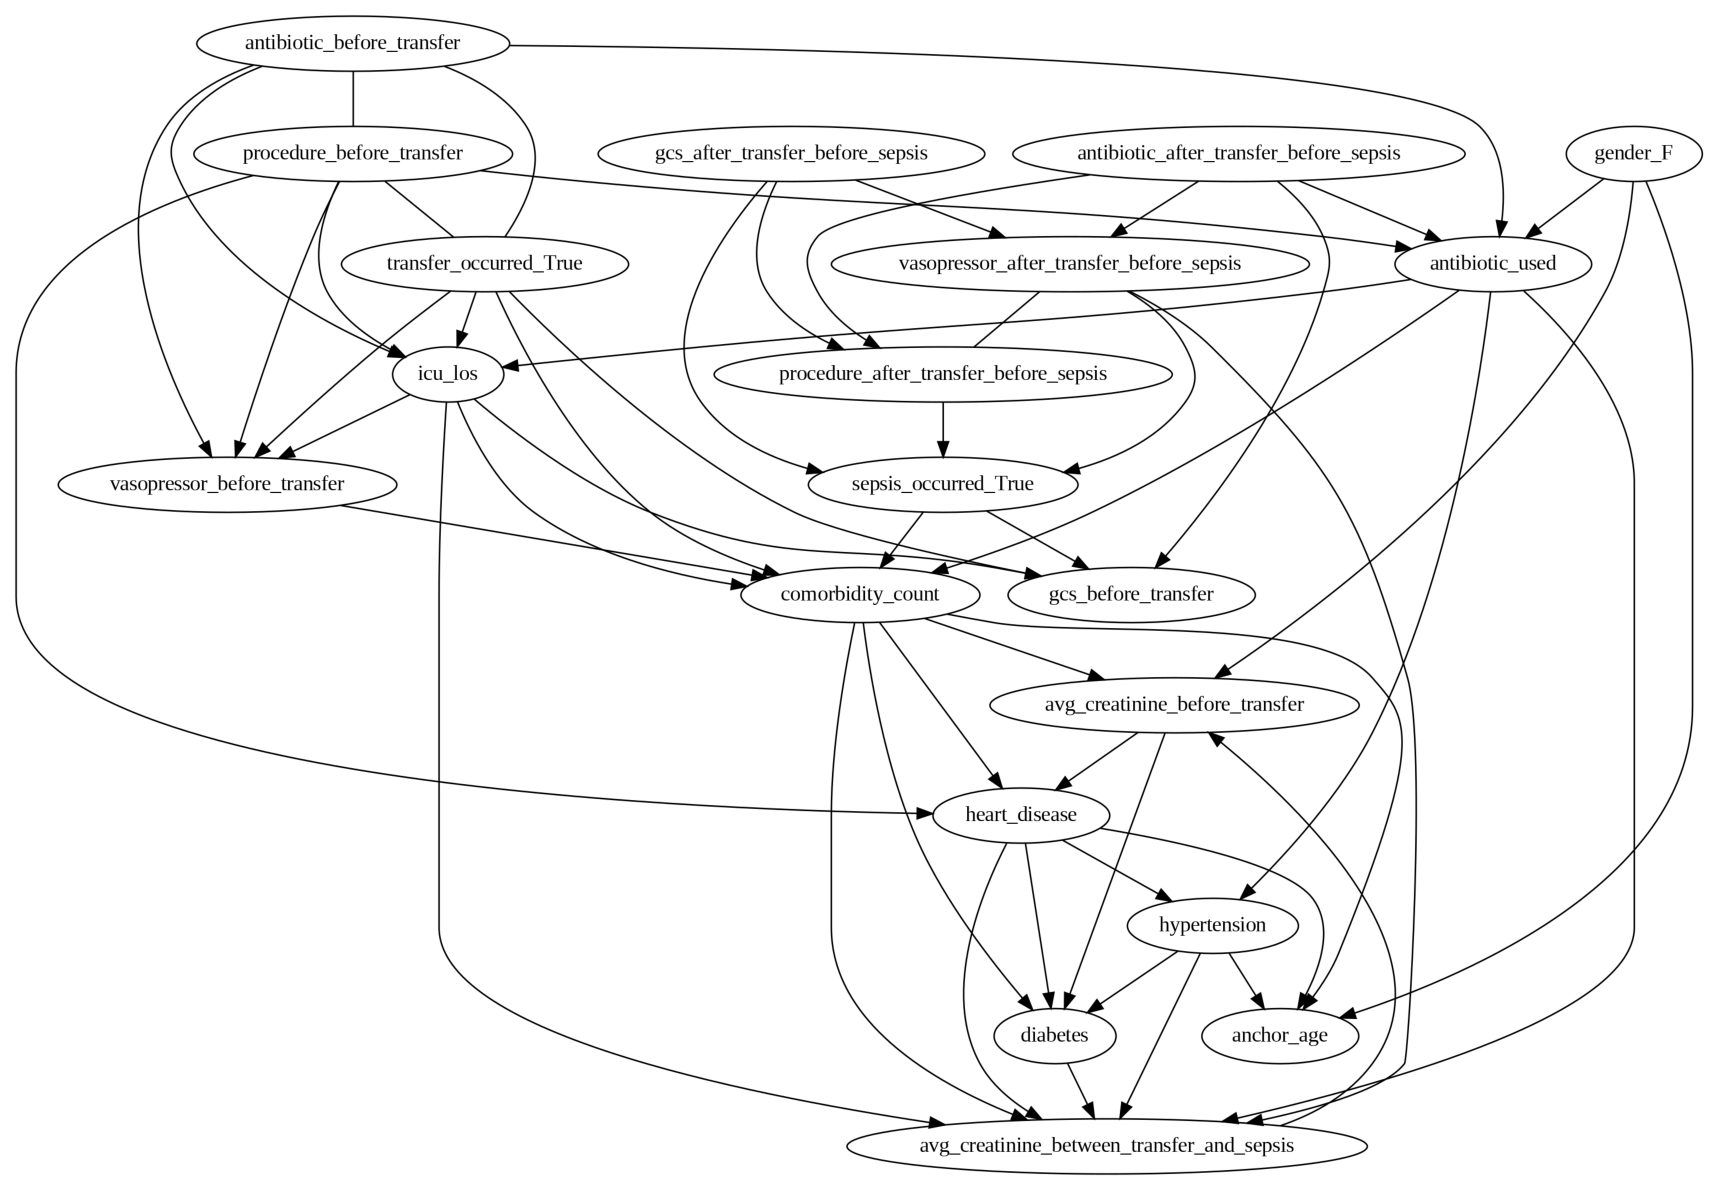

In [107]:
# Draw the graph with updated labels
pc_result.draw_pydot_graph(labels=node_labels)

In [128]:
# Customize labels in the graph
node_labels = {i: column_name for i, column_name in enumerate(dataset.columns)}

In [129]:
fci_g, fci_edges = fci(data)

  0%|          | 0/20 [00:00<?, ?it/s]

X1 --> X2
X1 --> X6
X1 --> X8
X2 --> X9
X17 --> X2
X6 --> X8
X7 --> X8
X19 --> X9
X11 --> X10
X12 --> X10
X18 --> X11
X16 --> X12
X13 --> X17
X14 --> X19
X18 --> X17


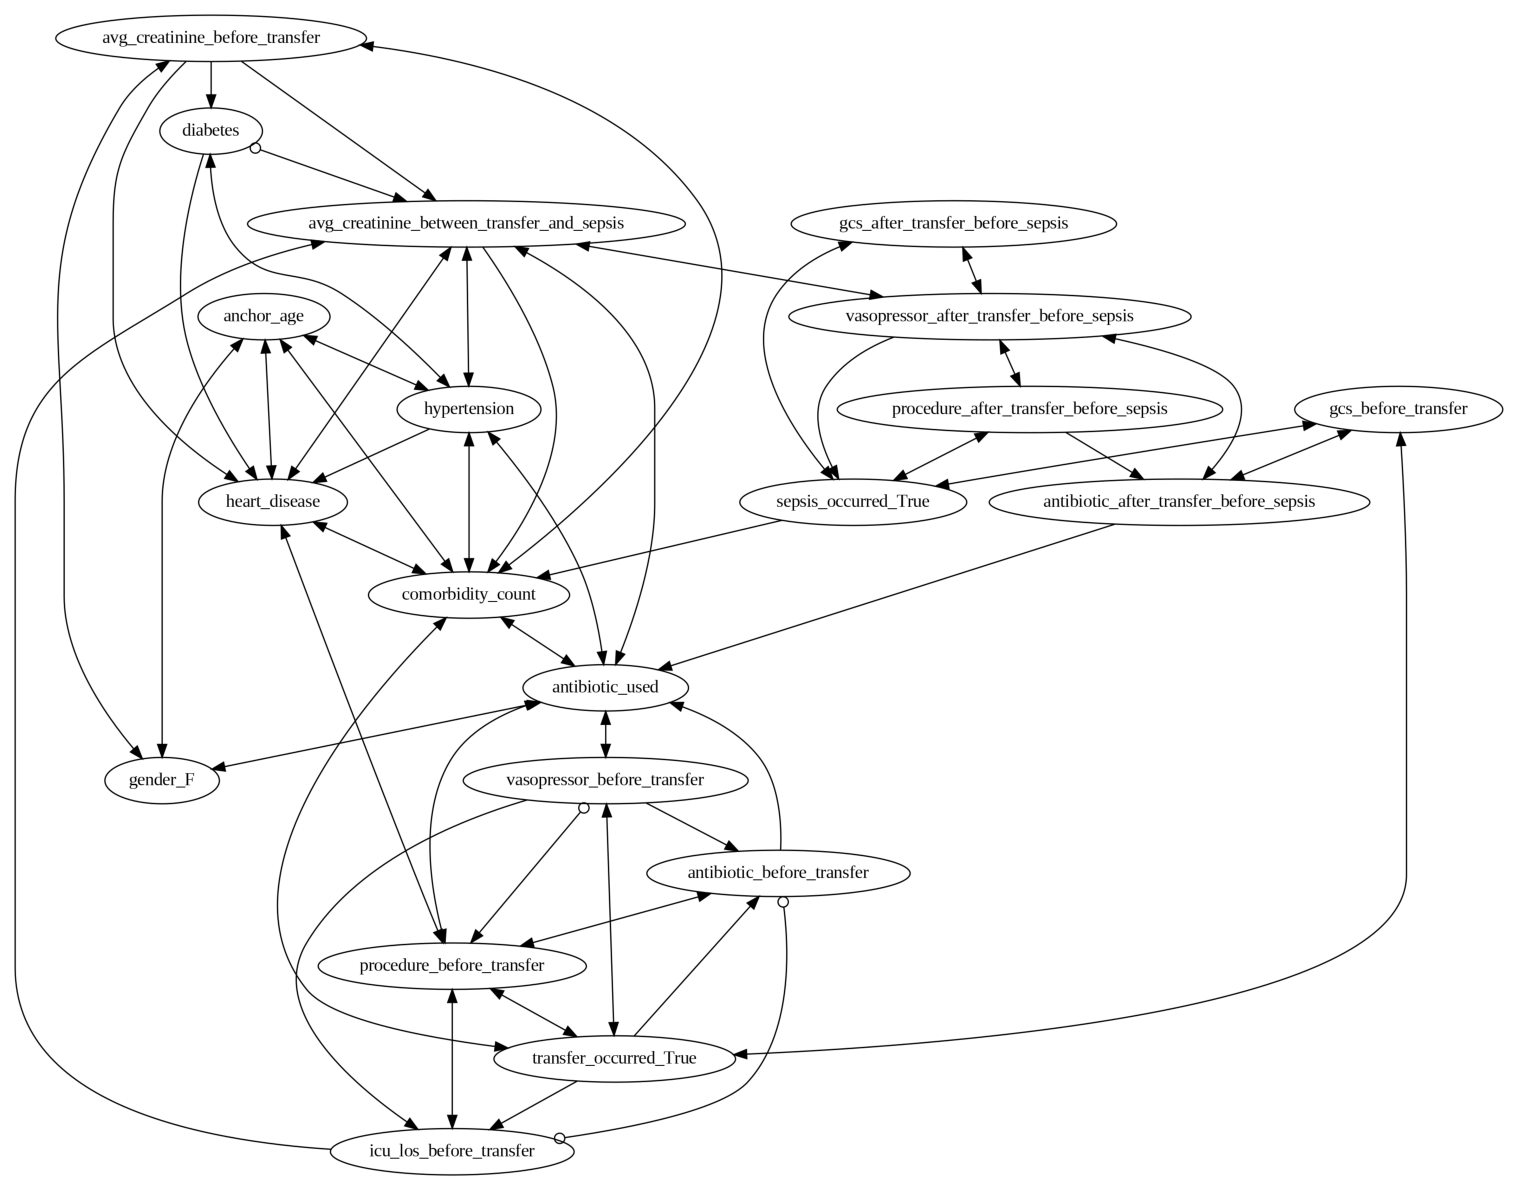

In [147]:
pyd = GraphUtils.to_pydot(fci_g, labels=node_labels)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

In [135]:
treatment = dataset['transfer_occurred_True']
outcome = dataset['sepsis_occurred_True']
covariates = dataset[['gcs_before_transfer', 'comorbidity_count']]

In [136]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
covariates_scaled = scaler.fit_transform(covariates)

In [137]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(covariates_scaled, treatment)

propensity_scores = model.predict_proba(covariates_scaled)[:, 1]
dataset['propensity_score'] = propensity_scores

In [138]:
from sklearn.neighbors import NearestNeighbors

treated = dataset[treatment == 1]
control = dataset[treatment == 0]

nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])

distances, indices = nn.kneighbors(treated[['propensity_score']])
matched_controls = control.iloc[indices.flatten()]
matched_treated = treated.reset_index(drop=True)


In [139]:
matched_dataset = pd.concat([matched_treated, matched_controls], axis=0)


In [140]:
def compute_smd(covariates_treated, covariates_control):
    treated_mean = covariates_treated.mean()
    control_mean = covariates_control.mean()
    pooled_std = ((covariates_treated.std()**2 + covariates_control.std()**2) / 2)**0.5
    return abs(treated_mean - control_mean) / pooled_std

covariate_balance = {col: compute_smd(
    matched_dataset[matched_dataset['transfer_occurred_True'] == 1][col],
    matched_dataset[matched_dataset['transfer_occurred_True'] == 0][col])
    for col in covariates.columns}
print(covariate_balance)


{'gcs_before_transfer': 0.008174197065527628, 'comorbidity_count': 0.0020378067878014383}


In [141]:
ate = matched_dataset[matched_dataset['transfer_occurred_True'] == 1]['sepsis_occurred_True'].mean() - \
      matched_dataset[matched_dataset['transfer_occurred_True'] == 0]['sepsis_occurred_True'].mean()
print("Estimated ATE:", ate)


Estimated ATE: 0.0037735849056603783


In [142]:
att = matched_treated['sepsis_occurred_True'].mean() - matched_controls['sepsis_occurred_True'].mean()
print("Estimated ATT:", att)


Estimated ATT: 0.0037735849056603783


In [143]:
weights = treatment / propensity_scores + (1 - treatment) / (1 - propensity_scores)
dataset['weights'] = weights

In [149]:
import statsmodels.api as sm
treatment = treatment.astype(float)
outcome = outcome.astype(float)
X = sm.add_constant(treatment)  # Add intercept
model = sm.WLS(outcome, X, weights=weights).fit()
print("Estimated ATE (IPTW):", model.params[1])

Estimated ATE (IPTW): -0.0022067808246811356


<ipython-input-149-b42a0d302ac0>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Estimated ATE (IPTW):", model.params[1])
